# AOMA long term with reference based Cov-SSI from STRID package

In [6]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import welch_plot, stabilization_diagram
import os
import koma.oma, koma.plot
import koma.clustering
import strid
from time import time
import pandas as pd

In [7]:
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz
bridgedeck_only = True

loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5', bridgedeck_only=bridgedeck_only)

In [8]:
#Parameters
i = 50 #number of block rows
s = 6
fs = 2
orders = np.arange(2, 100+2, 2) #orders to perform system

if bridgedeck_only:
    ix_references_y = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+16)
    ix_references_z = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+32)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()
else:
    ix_references_y = (np.array([1,3,5,7,11,13,17,19])+22)
    ix_references_z = (np.array([1,3,5,7,11,13,17,19])+44)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()

Number of perdiods to run 88


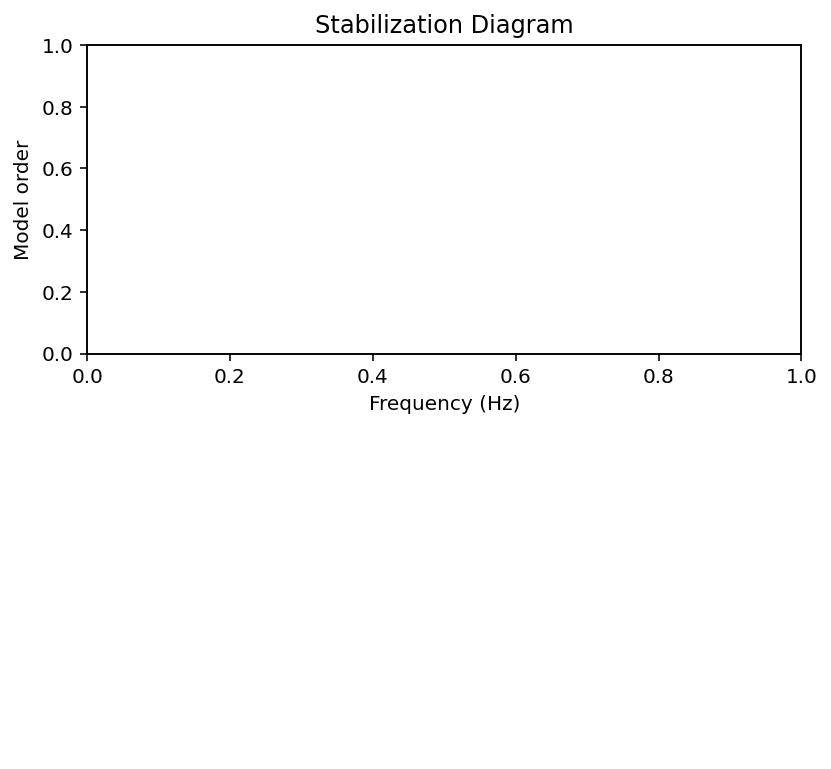

In [9]:
number_of_periods = len(loader.periods)
print("Number of perdiods to run " + str(number_of_periods))
freq_modes = []
number_in_sample = 2*60*analysis_length
stabdiag = strid.StabilizationDiagram()

In [ ]:
skipped = 0
for period in range(number_of_periods-65):
    #remove 10 periods and start at the 10th period
    acc = loader.load_all_acceleration_data(loader.periods[period], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)

    #print(type(acc))
    #If all channels are present, proceed with split up in intervals and perform Cov-SSI and clustering, if not, move to the next period
    if isinstance(acc, np.ndarray):
        acc = np.array_split(acc, acc.shape[0]/number_in_sample)
        #print(len(acc))

        for j in range(len(acc)):

            t0 = time()

            #Cov-SSI call
            ssid = strid.CovarianceDrivenStochasticSID(acc[j].transpose(), fs, ix_references)
            modes = {}
            for order in orders:
                A, C, G, R0 = ssid.perform(order, i)
                modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)
            modes = stabdiag.filter_modes(modes)

            orders = []
            lambdas = []
            phis = []

            for order in modes.keys():
                modes_in_order = modes[order]
                for mode in modes_in_order:
                    orders.append(order)
                    lambdas.append(mode.eigenvalue)
                    phis.append(mode.eigenvector)

            orders = np.array(orders)
            lambdas = np.array(lambdas)
            phis = np.array(phis).transpose()

            #Pole clustering
            pole_clusterer = koma.clustering.PoleClusterer(lambdas, phis, orders, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 0.5})
            prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
            args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

            xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

            #plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

            xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
            fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

            xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
            fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

            #Save stabilization plot
            stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)
            plt.savefig("plots/stab_diag/stabilization_diagram_" + str(period+1) + "_" + str(j+1) + ".jpg")

            freq_modes.append([freq for freq in fn_mean])

            #Write results to file
            res_data = np.vstack([fn_mean, 100*xi_mean]).T
            results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
            results.to_csv(path_or_buf='results.csv', mode='a')

            t1 = time()
            print("Time serie " + str(j+1) + " of " + str(len(acc)) + " done in " + str(t1-t0) + " sec. Period " + str(period+1) + " of " + str(number_of_periods) + " done. Number of skipped periods: " + str(skipped)+".")

    else:
        skipped += 1
        print("One or more channels are missing, period skipped.")

One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
One or more channels are missing, period skipped.
X-vector shape: (57600, 16)
Y-vector shape: (57600, 16)
Z-vector shape: (57600, 16)
Total-vector shape: (57600, 48)


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 1 of 16 done in 12.640115976333618 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 2 of 16 done in 14.629796981811523 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 3 of 16 done in 18.998271942138672 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 4 of 16 done in 17.653305768966675 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 5 of 16 done in 18.897298097610474 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 6 of 16 done in 13.55715298652649 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 7 of 16 done in 18.465502977371216 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 8 of 16 done in 16.03445792198181 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 9 of 16 done in 21.57580327987671 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 10 of 16 done in 18.230009078979492 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 11 of 16 done in 10.906304121017456 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 12 of 16 done in 12.2587308883667 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 13 of 16 done in 15.359901189804077 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 14 of 16 done in 15.520312070846558 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 15 of 16 done in 19.670196294784546 sec. Period 13 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 16 of 16 done in 17.9152672290802 sec. Period 13 of 88 done. Number of skipped periods: 12.
X-vector shape: (57600, 16)
Y-vector shape: (57600, 16)
Z-vector shape: (57600, 16)
Total-vector shape: (57600, 48)


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 1 of 16 done in 12.728109121322632 sec. Period 14 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 2 of 16 done in 12.935531854629517 sec. Period 14 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 3 of 16 done in 15.899905681610107 sec. Period 14 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 4 of 16 done in 18.10115909576416 sec. Period 14 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)
/Users/emilneby/PyCharmProjects/AOMA_Halogaland/dataloader_halogaland/plot.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax =plt.subplots(figsize=(14, 5), dpi=300)


Time serie 5 of 16 done in 19.20974111557007 sec. Period 14 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 6 of 16 done in 20.974549770355225 sec. Period 14 of 88 done. Number of skipped periods: 12.


/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_25455/38580619.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc[j], fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


Time serie 7 of 16 done in 16.933176040649414 sec. Period 14 of 88 done. Number of skipped periods: 12.
